In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mlp

In [79]:
data = pd.read_csv('Datasets/AirPassengers.csv', index_col='Month', parse_dates=['Month'])
data = data.rename(columns ={'#Passengers':'no_passengers'})
data

,no_passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


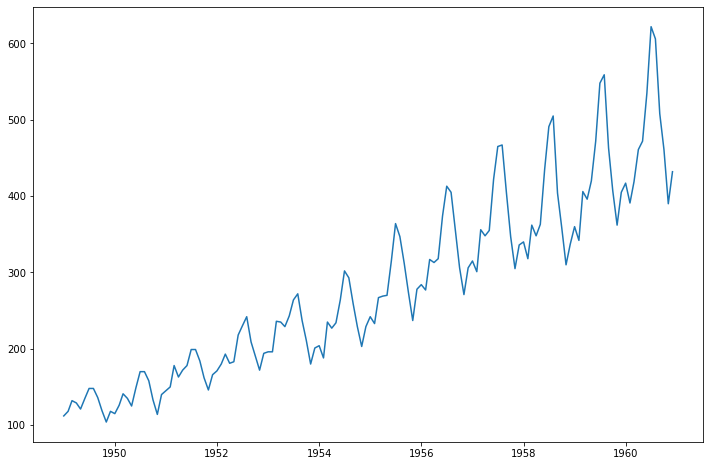

In [80]:
plt.plot(data)
plt.show()

In [81]:
data_for_dist_fitting = data[-70:]
data_train = data[~data.isin(data_for_dist_fitting).all(1)]
test_data = data_for_dist_fitting[-20:]
data_for_dist_fitting=data_for_dist_fitting[~data_for_dist_fitting.isin(test_data).all(1)]

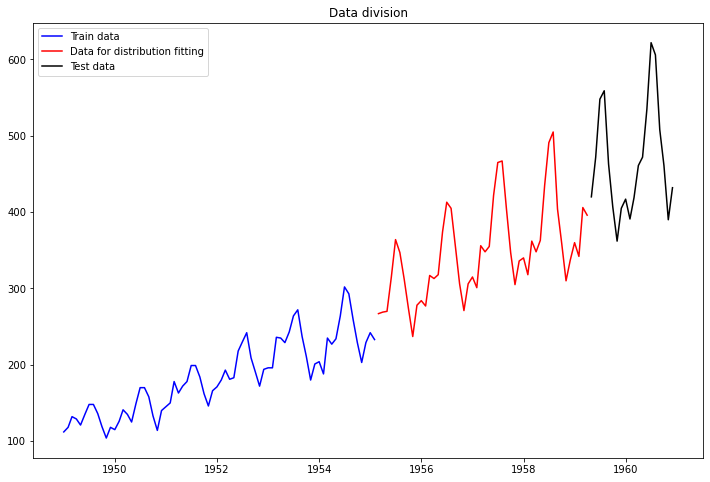

In [82]:
#plotting Data division
train = plt.plot(data_train,color='blue', label = 'Train data')
data_f_mc = plt.plot(data_for_dist_fitting, color ='red', label ='Data for distribution fitting')
test = plt.plot(test_data, color ='black', label = 'Test data')
plt.legend(loc='best') 
plt.title('Data division')
plt.show(block=False) 

In [83]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #plot rolling statistics:
    orig = plt.plot(timeseries,color='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False) 
    
    #Perform Dickey Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

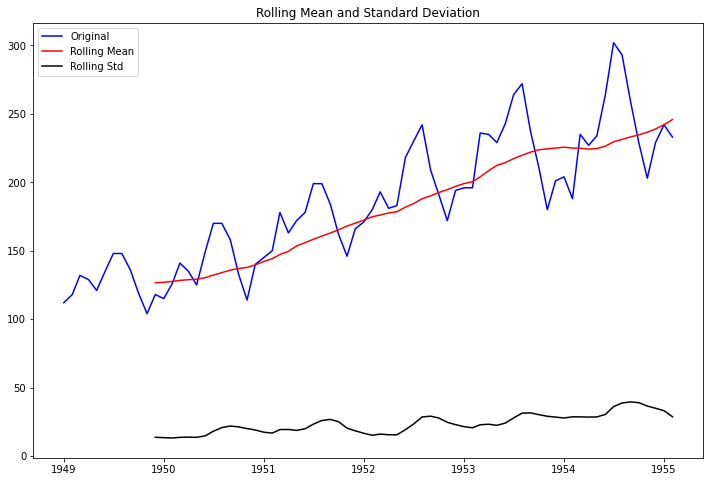

Results of Dickey Fuller Test:
Test Statistic                 -0.076786
p-value                         0.951702
#Lags Used                     12.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [84]:
test_stationarity(data_train)

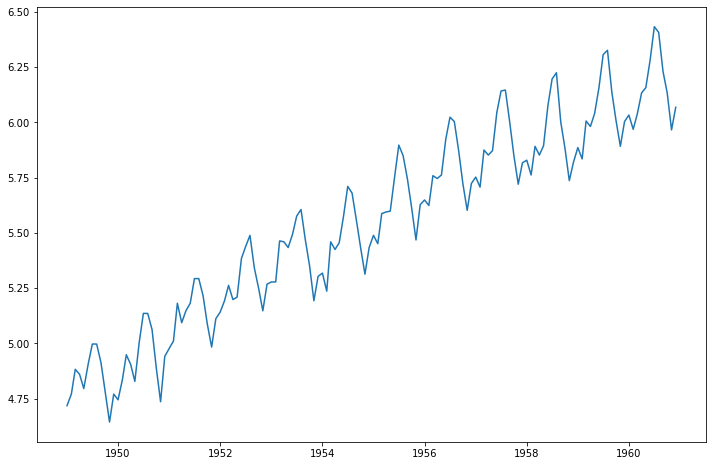

In [85]:
ts_log = np.log(data)
plt.plot(ts_log)
plt.show()

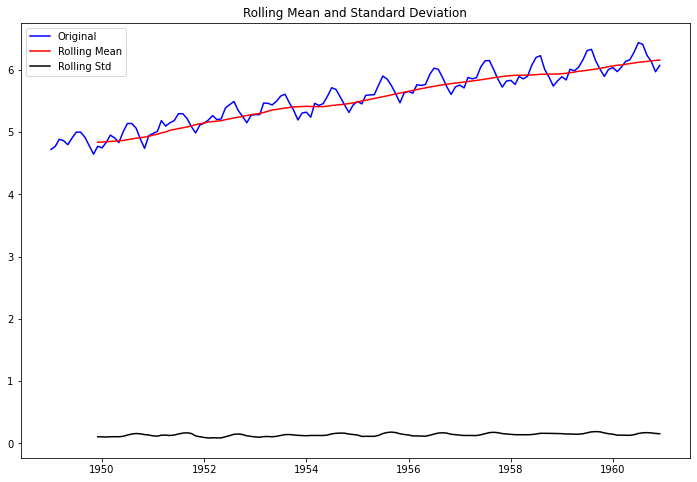

Results of Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [86]:
test_stationarity(ts_log)

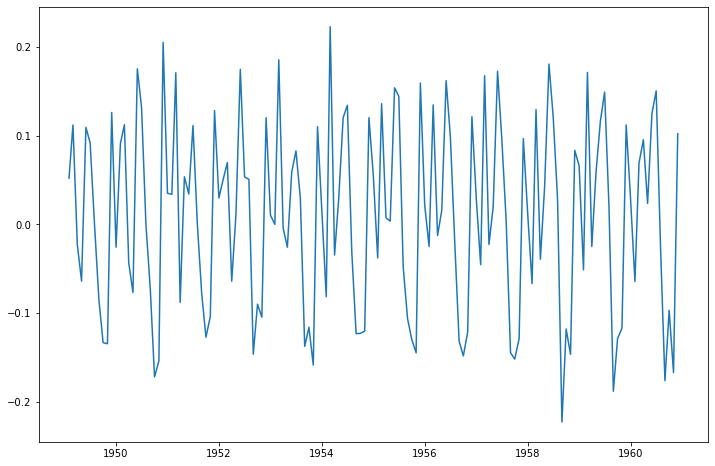

In [87]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

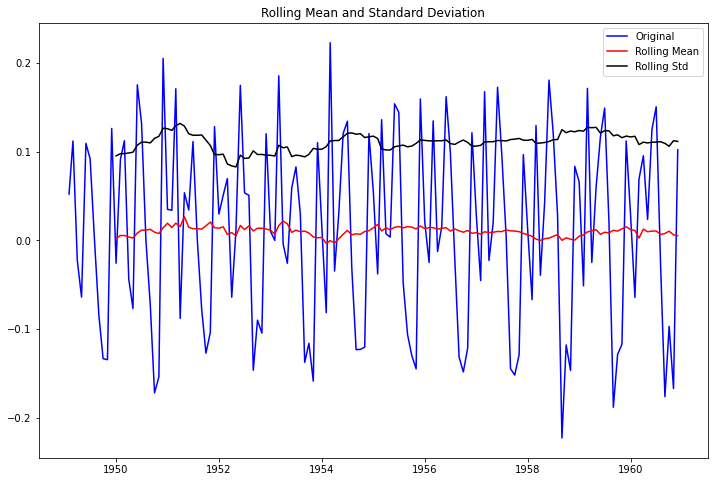

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [88]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

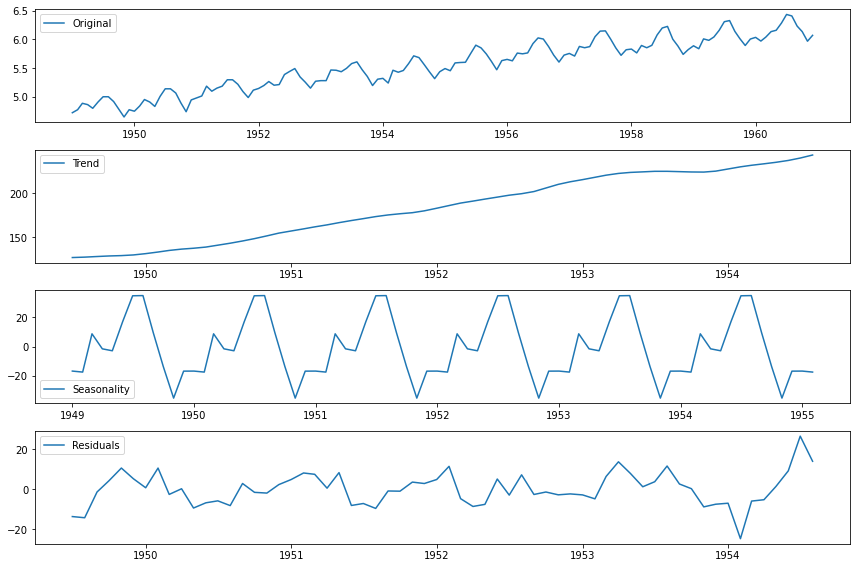

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_train)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [90]:
#SARIMA MODEL

In [60]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [91]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except Exception as E: 
            print(E)
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:976.2000634372041
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:772.452098865035
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:576.0812438120935
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:456.93966479392475
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:506.9582765621536
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:484.68773558295896
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:451.02812400438347
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:422.0381775329636
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.668936507398
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:686.1743315344686
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:524.9528579387913
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:423.38151063115185
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:509.7635632549144
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:457.3295772168519
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:434.5738205552504
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:399.4646662640449
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:631.1553659853364
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:507.0775

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

mod= SARIMAX(data_train,order=(1,1,1),seasonal_order=(1, 1, 1, 12),enforce_invertibility=False, enforce_stationarity=False)
results = mod.fit(disp=0)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      no_passengers   No. Observations:                   74
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -172.025
Date:                            Wed, 02 Mar 2022   AIC                            354.050
Time:                                    14:49:42   BIC                            363.301
Sample:                                01-01-1949   HQIC                           357.531
                                     - 02-01-1955                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8316      0.179     -4.637      0.000      -1.183      -0.480
ma.L1          0.6404      0.223   

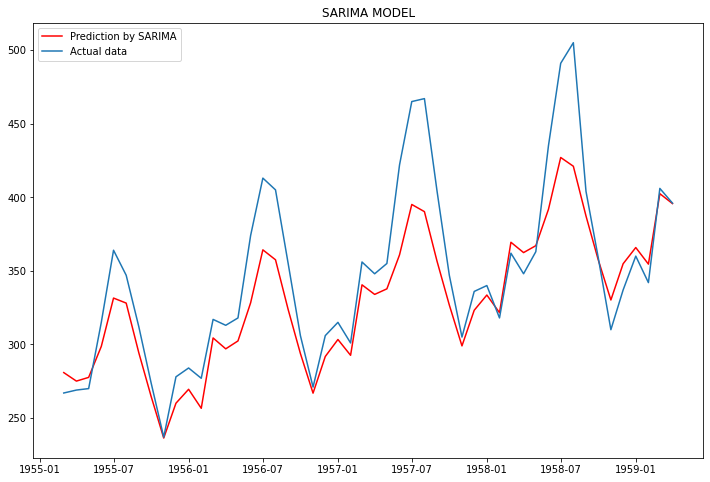

In [93]:
pred_sarima = results.forecast(50)
predicted =plt.plot(pred_sarima,label='Prediction by SARIMA', color='red')
Actual = plt.plot(data_for_dist_fitting,label='Actual data')
plt.legend(loc='best') 
plt.title('SARIMA MODEL')
plt.show(block=False) 

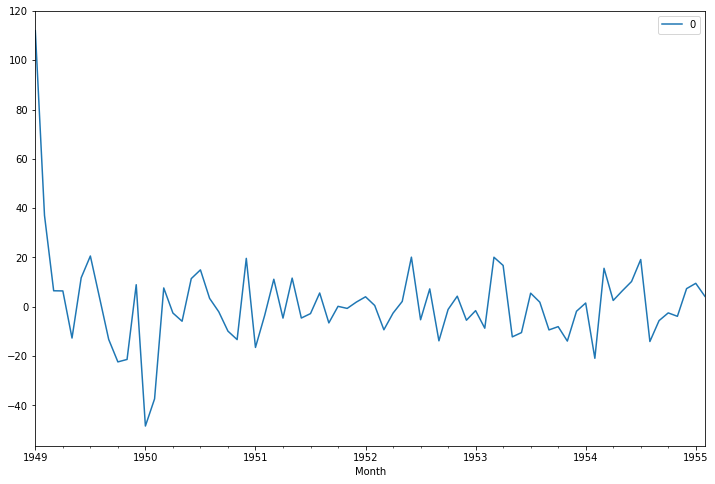

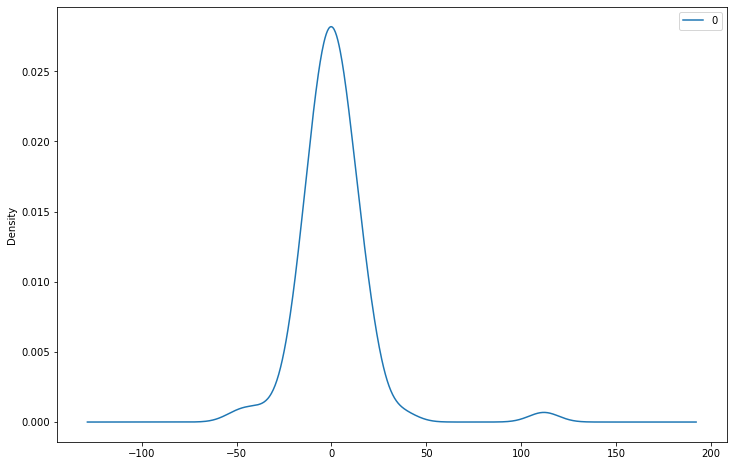

                0
count   74.000000
mean     0.993986
std     18.611649
min    -48.409166
25%     -7.703533
50%     -0.263910
75%      7.314967
max    112.000000


In [94]:
# plot residual errors of the training data
residual_error = pd.DataFrame(results.resid)
residual_error.plot()
plt.show()
residual_error.plot(kind='kde')
plt.show()
print(residual_error.describe())

Test MSE: 122.773


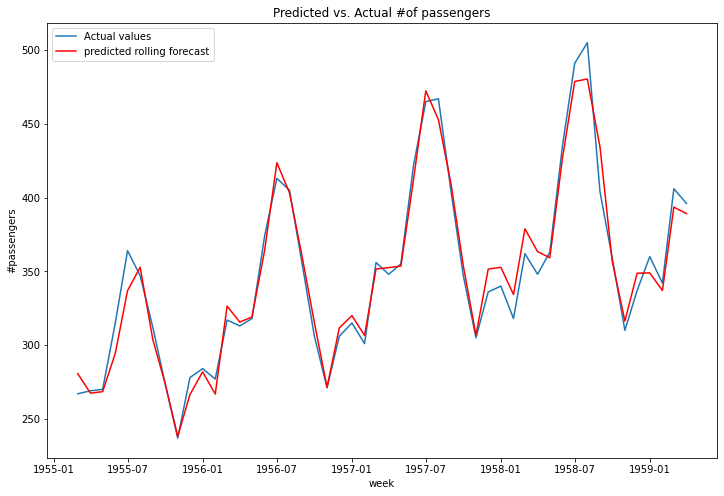

In [95]:
#to suppress warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

#creating new dataframe for rolling forescast
history = np.log(data_train.astype(float))
predictions = list()

for i in range(len(data_for_dist_fitting)): 
    model = SARIMAX(history,order=(1,1,1),seasonal_order=(1, 1, 1, 12),enforce_invertibility=False, enforce_stationarity=False)
    model_fit = model.fit(disp = 0)
    # generate forcecast for next period
    output = model_fit.forecast()
    #Save the prediction value in yhat
    yhat = np.e ** output[0]
    #Append yhat to the list of prediction
    predictions.append(yhat)
    # grabs the observation at the ith index
    obs = data_for_dist_fitting[i : i + 1]
    # appends the observation to the estimation data set
    history = history.append(np.log(obs.astype(float)))
    
# prints the MSE of the model for the rolling forecast period
error = mean_squared_error(data_for_dist_fitting, predictions)
print('Test MSE: %.3f' % error)

# converts the predictions list to a pandas dataframe with the same index as the actual values
# for plotting purposes
predictions = pd.DataFrame(predictions)
predictions.index = data_for_dist_fitting.index

# sets the plot size to 12x8
mlp.rcParams['figure.figsize'] = (12,8)

# plots the predicted and actual stock prices 
plt.plot(data_for_dist_fitting,label='Actual values')
plt.plot(predictions, color = 'red', label='predicted rolling forecast')
plt.legend(loc='best')
plt.xlabel('week')
plt.ylabel('#passengers')
plt.title('Predicted vs. Actual #of passengers')
plt.show()

count    50.000000
mean     -0.294307
std      11.188824
min     -30.306601
25%      -6.633109
50%      -0.756089
75%       7.927897
max      27.081600
dtype: float64

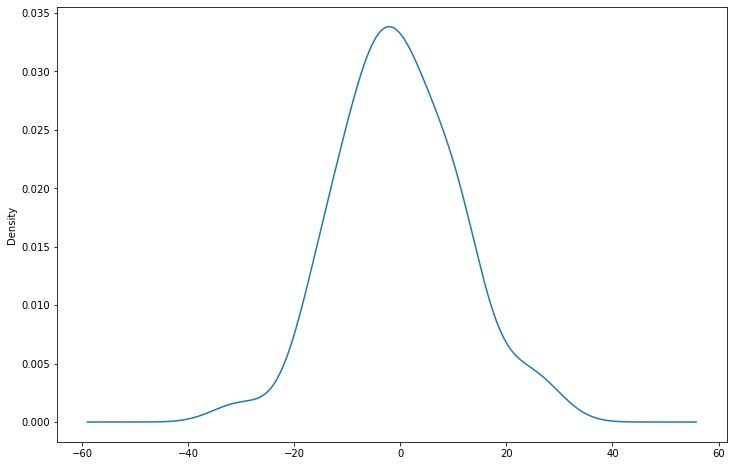

In [96]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mlp.rcParams['figure.figsize'] = (12,8)

# plots the rolling forecast error 
rf_errors = data_for_dist_fitting.no_passengers - predictions[0]
rf_errors.plot(kind = 'kde')
# produces a summary of rolling forecast error 
rf_errors.astype(float).describe()

,sumsquare_error,aic,bic,kl_div
norm,0.066105,893.846035,-323.602410,inf
laplace,0.068599,905.388319,-321.750897,inf
uniform,0.081375,813.967747,-313.211629,inf
binomial,inf,inf,inf,inf


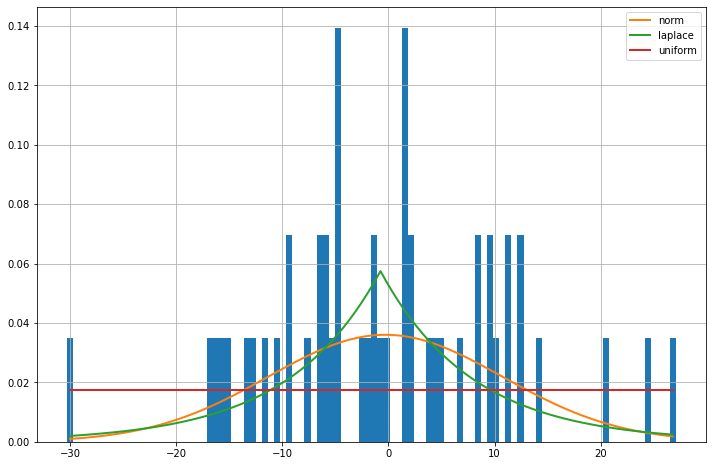

In [97]:
# to suppress warnings
import warnings
warnings.filterwarnings('ignore')

# imports the fitter function and produces estimated fits for our rsarima_errors
from fitter import Fitter,get_common_distributions,get_distributions


f = Fitter(rf_errors, distributions=['binomial','norm','laplace','uniform'])
f.fit()
f.summary()


In [99]:
# creates a function to do MC simulation with a Laplacian distribution
def lapace_mc_randv_distribution(mean, rf_errors, n_sim):
    # gets the estimated beta or mean absolute distance from the mean
    var = (sum(abs(rf_errors - np.mean(rf_errors))) 
                           / len(rf_errors))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean,var,n_sim)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)
def rolling_forecast_MC(train, test, std_dev, n_sims):
    # create a new dataframe that will be added to as the forecast rolls 
    history = np.log(data_train.astype(float))
    # create an empty list that will hold predictions
    predictions = list()

    # loops through the indexes of the set being forecasted
    for i in range(len(test_data)): 
        model = SARIMAX(history,order=(1,1,1),seasonal_order=(1, 1, 1, 12),enforce_invertibility=False, enforce_stationarity=False)
        model_fit = model.fit(disp = 0)
        # generate forcecast for next period
        output = model_fit.forecast().values
        #Save the prediction value in yhat       
        yhat = np.e ** output[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        randv_range = lapace_mc_randv_distribution(yhat,std_dev,n_sims)
        #Append yhat to the list of prediction
        predictions.append([float(i) for i in randv_range])
        # grabs the observation at the ith index
        obs = test_data[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))
        
    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    predictions.index = test_data.index
        
    # returns predictions
    return(predictions)

In [100]:
# attaches the data withheld for investigating the forecast residuals back to the training
# data set to avoid a large error on the first forecast
data_train = data_train.append(data_for_dist_fitting)

# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds = rolling_forecast_MC(data_train, 
                               test_data, 
                               rf_errors,
                              1000)

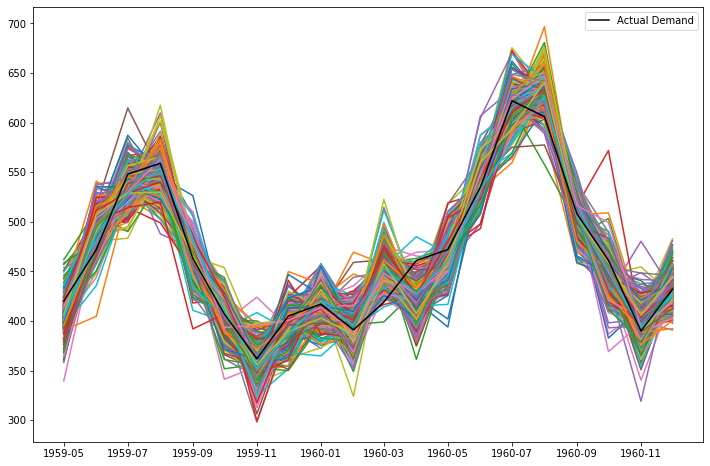

In [101]:
MC = plt.plot(test_preds)
Actual=plt.plot(test_data,color='black',label='Actual Demand')
plt.legend(loc='best')
plt.show()

In [103]:
print('Expected demand:',np.mean(test_preds.values))
print('Quantile(5%):',np.percentile(test_preds,5))
print('Quantile(95%):',np.percentile(test_preds,95))

Expected demand: 466.309842666895
Quantile(5%): 369.17223680234474
Quantile(95%): 623.1327529849755


In [104]:
def rolling_forecast_MC_for_minmax_range(train, test, std_dev, n_sims):
    # create a new dataframe that will be added to as the forecast rolls 
    history = np.log(data_train.astype(float))
    # create an empty list that will hold predictions
    predictions = list()

    # loops through the indexes of the set being forecasted
    for i in range(len(test_data)): 
        model = SARIMAX(history,order=(1,1,1),seasonal_order=(1, 1, 1, 12),enforce_invertibility=False, enforce_stationarity=False)
        model_fit = model.fit(disp = 0)
        # generate forcecast for next period
        output = model_fit.forecast().values
        #Save the prediction value in yhat       
        yhat = np.e ** output[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        randv_range = lapace_mc_randv_distribution(yhat,std_dev,n_sims)
        #Append yhat to the list of prediction
        predictions.append([float(i) for i in randv_range])
        # grabs the observation at the ith index
        obs = test_data[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))
        
    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    # converts all the estimated yhats in each column to one list per row
    predictions['predicted_range'] = predictions.values.tolist()
    # grabs only the column with all values in a list
    predictions = pd.DataFrame(predictions['predicted_range'])
    predictions.index = test_data.index
        
    # returns predictions
    return(predictions)

In [105]:
# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds_minmax = rolling_forecast_MC_for_minmax_range(data_train, 
                               test_data, 
                               rf_errors,
                              1000)

In [106]:
test_preds_minmax.head()

,predicted_range
Month,
1959-05-01,"[407.5461033027577, 393.6161366947815, 389.939..."
1959-06-01,"[493.6006061735357, 488.993030106729, 495.1562..."
1959-07-01,"[549.1045330176355, 518.6473770397467, 520.911..."
1959-08-01,"[551.5769551962975, 551.65211334223, 554.92572..."
1959-09-01,"[466.9410511012042, 493.02246008680675, 465.62..."


In [107]:
# creates an empty list
prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(test_data)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    prediction_interval.append(np.where(min(test_preds_minmax.predicted_range[i]) <= 
                                           test_data.no_passengers[i]
                                          <= max(test_preds_minmax.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Demand in Predicted Demand Range: %f' % 
      (100 * sum(prediction_interval) / len(prediction_interval)))

Percentage of Demand in Predicted Demand Range: 100.000000


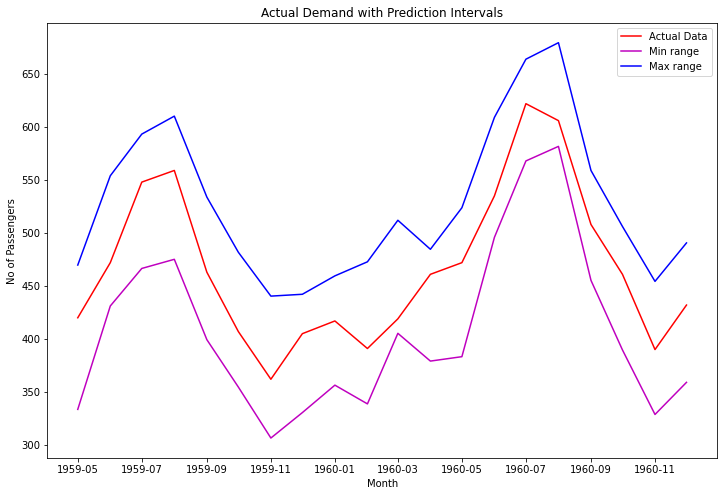

In [108]:
# creates empty lists to append to with minimum and maximum values for each weeks prediction
min_range = []
max_range = []

# loops through the rows in test_preds
for i in range(len(test_preds_minmax)):
    # appends to the list the min or max value as appropriate
    min_range.append(min(test_preds_minmax.predicted_range[i]))
    max_range.append(max(test_preds_minmax.predicted_range[i]))
    
# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = test_data.index
max_range = pd.DataFrame(max_range)
max_range.index = test_data.index

# plots the actual stock price with prediction intervals
plt.plot(test_data, color ='red',label='Actual Data')
plt.plot(min_range, color = 'm', label='Min range')
plt.plot(max_range, color = 'b', label ='Max range')
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('No of Passengers')
plt.title('Actual Demand with Prediction Intervals')
plt.show()